In [1]:
""" 
GRU-CNN Model Adapted from Maira Alvi's ICONIP21 GitHub Repository:
https://github.com/MairaAlvi/ICONIP21 [Last Accessed: 2022-05-22]
"""

In [2]:
import numpy as np
import pandas as pd
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split, KFold
from sklearn.metrics import mean_squared_error


import tensorflow.keras as keras


In [28]:
df = pd.read_csv(os.path.join("data", "final_df.csv"))
df['Cell Count (million per mL)'].min()*0.1

0.010000000000000002

In [40]:
df['Cell Count (million per mL)'].mean() - df['Cell Count (million per mL)'].std()

0.3740238162566364

In [4]:
x_arr = np.array(df.drop(columns=['Cell Count (million per mL)']), np.float32)
x_shaped = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])

y_shaped = df['Cell Count (million per mL)'].values

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(x_shaped)

print(kf)


KFold(n_splits=5, random_state=None, shuffle=True)


In [41]:
df.columns

Index(['pH', 'Temperature (°C)', 'D.O. (mg/L)', 'Cell Count (million per mL)',
       'NO3-N (mg/L)', 'NH4-N (mg/L)', 'ORP (MV)', 'Conductivity (mS/cm)',
       'Turbidity (NTU)'],
      dtype='object')

In [6]:
model = keras.models.load_model('best_model')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 100)         33000     
                                                                 
 gru_1 (GRU)                 (None, None, 144)         106272    
                                                                 
 reshape (Reshape)           (None, 12, 12)            0         
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           6272      
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                        

In [7]:
#Freeze layers   
for layer in model.layers[:3]:
    print(layer)
    layer.trainable = False

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 100)         33000     
                                                                 
 gru_1 (GRU)                 (None, None, 144)         106272    
                                                                 
 reshape (Reshape)           (None, 12, 12)            0         
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           6272      
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                        

In [8]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.000005),  
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()]
        )

In [20]:
models = []
histories = []  
model_evals = []
early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, monitor='loss')
for train_index, test_index in kf.split(x_shaped):
    x_train, x_test = x_shaped[train_index], x_shaped[test_index]
    y_train, y_test = y_shaped[train_index], y_shaped[test_index]

    history = model.fit(x_train,y_train,epochs=100000, callbacks=[early_stopping])
    
    model_eval = model.evaluate(x_test, y_test)
    models.append(model)
    histories.append(history)
    model_evals.append(model_eval)
        

Epoch 1/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0345 - root_mean_squared_error: 0.1856
Epoch 2/100000
5/5 [==============================] - 0s 6ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824
Epoch 3/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0356 - root_mean_squared_error: 0.1887
Epoch 4/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819
Epoch 5/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811
Epoch 6/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0334 - root_mean_squared_error: 0.1827
Epoch 7/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836
Epoch 8/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0325 - root_mean_squared_error: 0.1803
Epoch 9/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0316

5/5 [==============================] - 0s 4ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597
Epoch 142/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0299 - root_mean_squared_error: 0.1729
Epoch 143/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590
Epoch 144/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630
Epoch 145/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589
Epoch 146/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0252 - root_mean_squared_error: 0.1586
Epoch 147/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571
Epoch 148/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615
Epoch 149/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.027

5/5 [==============================] - 0s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526
Epoch 282/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542
Epoch 283/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553
Epoch 284/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1540
Epoch 285/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0226 - root_mean_squared_error: 0.1505
Epoch 286/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
Epoch 287/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575
Epoch 288/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555
Epoch 289/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.022

5/5 [==============================] - 0s 5ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503
Epoch 422/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557
Epoch 423/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471
Epoch 424/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - root_mean_squared_error: 0.1536
Epoch 425/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459
Epoch 426/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1498
Epoch 427/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471
Epoch 428/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483
Epoch 429/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.022

5/5 [==============================] - 0s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453
Epoch 562/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453
Epoch 563/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460
Epoch 564/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467
Epoch 565/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469
Epoch 566/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417
Epoch 567/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413
Epoch 568/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436
Epoch 569/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.024

5/5 [==============================] - 0s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342
Epoch 116/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344
Epoch 117/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323
Epoch 118/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371
Epoch 119/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416
Epoch 120/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333
Epoch 121/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344
Epoch 122/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352
Epoch 123/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.019

5/5 [==============================] - 0s 3ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287
Epoch 256/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298
Epoch 257/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255
Epoch 258/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247
Epoch 259/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264
Epoch 260/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280
Epoch 261/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246
Epoch 262/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283
Epoch 263/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.015

5/5 [==============================] - 0s 4ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179
Epoch 396/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262
Epoch 397/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202
Epoch 398/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233
Epoch 399/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244
Epoch 400/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200
Epoch 401/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185
Epoch 402/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251
Epoch 403/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.015

5/5 [==============================] - 0s 3ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475
Epoch 92/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407
Epoch 93/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365
Epoch 94/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426
Epoch 95/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403
Epoch 96/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387
Epoch 97/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378
Epoch 98/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355
Epoch 99/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0191 - root

5/5 [==============================] - 0s 4ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317
Epoch 232/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373
Epoch 233/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292
Epoch 234/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340
Epoch 235/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317
Epoch 236/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349
Epoch 237/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275
Epoch 238/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291
Epoch 239/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.017

5/5 [==============================] - 0s 4ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240
Epoch 372/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262
Epoch 373/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218
Epoch 374/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217
Epoch 375/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272
Epoch 376/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333
Epoch 377/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212
Epoch 378/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229
Epoch 379/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.015

5/5 [==============================] - 0s 4ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171
Epoch 512/100000
5/5 [==============================] - 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165
Epoch 513/100000
5/5 [==============================] - 0s 2ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209
Epoch 514/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239
Epoch 515/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
Epoch 516/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172
Epoch 517/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169
Epoch 518/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241
Epoch 519/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.013

5/5 [==============================] - 0s 4ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 652/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 653/100000
5/5 [==============================] - 0s 6ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145
Epoch 654/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153
Epoch 655/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137
Epoch 656/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 657/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 658/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123
Epoch 659/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.013

5/5 [==============================] - 0s 4ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368
Epoch 96/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418
Epoch 97/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347
Epoch 98/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376
Epoch 99/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327
Epoch 100/100000
5/5 [==============================] - 0s 0s/step - loss: 0.0187 - root_mean_squared_error: 0.1367
Epoch 101/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335
Epoch 102/100000
5/5 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400
Epoch 103/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0182 - r

5/5 [==============================] - 0s 4ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316
Epoch 236/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236
Epoch 237/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251
Epoch 238/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319
Epoch 239/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254
Epoch 240/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260
Epoch 241/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246
Epoch 242/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333
Epoch 243/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.015

5/5 [==============================] - 0s 4ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210
Epoch 376/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265
Epoch 377/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222
Epoch 378/100000
5/5 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 379/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 380/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202
Epoch 381/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190
Epoch 382/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283
Epoch 383/100000
5/5 [==============================] - 0s 878us/step - loss: 0.0

5/5 [==============================] - 0s 0s/step - loss: 0.0158 - root_mean_squared_error: 0.1258
Epoch 65/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277
Epoch 66/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348
Epoch 67/100000
5/5 [==============================] - 0s 888us/step - loss: 0.0165 - root_mean_squared_error: 0.1283
Epoch 68/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322
Epoch 69/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0158 - root_mean_squared_error: 0.1259
Epoch 70/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262
Epoch 71/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238
Epoch 72/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0155 - roo

5/5 [==============================] - 0s 752us/step - loss: 0.0136 - root_mean_squared_error: 0.1166
Epoch 205/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198
Epoch 206/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230
Epoch 207/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165
Epoch 208/100000
5/5 [==============================] - 0s 5ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204
Epoch 209/100000
5/5 [==============================] - 0s 3ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284
Epoch 210/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
Epoch 211/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229
Epoch 212/100000
5/5 [==============================] - 0s 4ms/step - loss: 0.0

In [53]:
np.mean([model_evals[0][1],model_evals[1][1],model_evals[2][1],model_evals[3][1],model_evals[4][1]])

0.229215207695961

In [21]:
best_loc = model_evals.index(min(model_evals))
best_model = models[best_loc]
best_history = histories[best_loc]
best_eval = model_evals[best_loc]

best_model.save('best_model_cell_count')

INFO:tensorflow:Assets written to: best_model_cell_count\assets


INFO:tensorflow:Assets written to: best_model_cell_count\assets


In [22]:
best_history.history.keys()

dict_keys(['loss', 'root_mean_squared_error'])

In [56]:

test_loss = best_eval[0]
test_rmse = best_eval[1]

now = dt.datetime.now().strftime("%Y-%m-%d %H-%M")

In [57]:
ffp_rmse = 0.03740238162566364

In [58]:
def check_file(fpath):
    return os.path.exists(fpath)

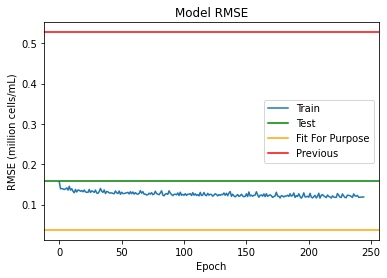

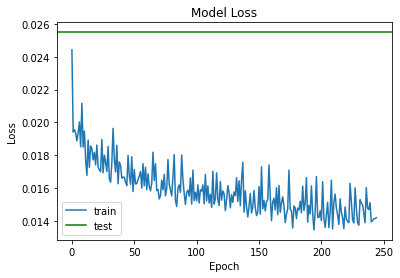

In [59]:
plt.plot(best_history.history['root_mean_squared_error'], label='Train')
plt.axhline(test_rmse, color='g', label='Test')
plt.axhline(ffp_rmse, color='orange', label='Fit For Purpose')
plt.axhline(0.5272, color='r',label="Previous")
plt.title('Model RMSE')
plt.ylabel('RMSE (million cells/mL)')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model RMSE vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

plt.plot(best_history.history['loss'], label='train')
plt.axhline(test_loss, color='g', label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model Loss vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

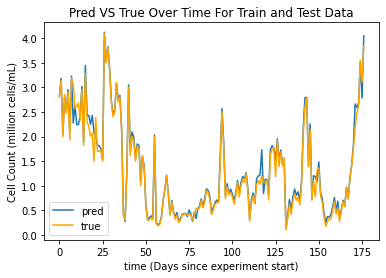

In [50]:
pred = best_model.predict(x_shaped)

plt.plot(pred, label='pred')
plt.plot(y_shaped, color='orange', label='true')
plt.title('Pred VS True Over Time For Train and Test Data')
plt.ylabel('Cell Count (million cells/mL)')
plt.xlabel('time (Days since experiment start)')
plt.legend()
fpath = os.path.join("plots", now + " Overall Acc Predicted and True vs Time" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()


In [60]:
test_rmse

0.1596573442220688